In [1]:
# Import modules
# ipython magic to plot in line
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
#matplotlib.style.use('ggplot')
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
import time
plt.rcParams.update({'figure.max_open_warning': 0})

# On Chinook (in CST) we need to tell python we want to display in CST (otherwise UTC is assumed)
if os.name=='posix': # Linux
    os.environ['TZ'] = 'CST'
    time.tzset()

In [2]:
Stations_all = ['BNS','CRG','CRN','FLG','FRG','FRS','PWL']
Station_full_names = ['Bonsai','Can. Ridge','Can. Ridge North','Fortress Ledge','Fortress Ridge','Fortress Ridge South','Powerline']

CST_to_MST = -1 # CST to MST
UTC_to_MST = -7 # UTC (model) to MST

In [3]:
# Set font size
font = {'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

In [4]:
# Directories
# Path to raw data
if os.name=='posix': # Linux
    # Linux path
    mod_dir   = os.path.normpath(r'/home/nwayand/snow_models/output_CHM/SnowCast/forecast/points')
    telm_dir  = os.path.normpath(r'/home/nwayand/WRF/data/hydrology_staff_shared/Centre/Marmot Creek/Telemetry/FortressMountain')
else: # Win path
    mod_dir   = os.path.normpath(r'C:\\Users\\new356\Model_Output\CHM\SnowCast\forecast\points')
    telm_dir  = os.path.normpath(r'Y:\Centre\Marmot Creek\Telemetry\FortressMountain')

# Model output ending
mod_ending   = '*_out.txt'

In [5]:
input_format = 'CHM'

In [6]:
if input_format == 'CHM':
    # Ascii data format info
    c_header = 1 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

In [7]:
# Move to Model dir
os.chdir(mod_dir) 

In [8]:
def get_recent_CRHO_data_from_telem(csta,data_dir):
    %matplotlib inline
    import os
    import numpy as np
    import pandas as pd
    from astropy.io import ascii

    c_header = 4 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

    # Load in file
    cfile = csta + '_0015.dat' # Format for 15 min file
    dat = ascii.read(os.path.join(data_dir,cfile),header_start=c_column_line,data_start=c_header,delimiter=c_delimiter,exclude_names='N/A')
    datain = pd.DataFrame(dat.as_array())

    # Replace -9999 with nan (recomended by netcdf)
    datain.replace(-9999,np.NaN,inplace=True)

    # Make TIMESTAMP the index
    datain['TIMESTAMP'] = datain['TIMESTAMP'].astype('datetime64[ns]')
    datain = datain.set_index('TIMESTAMP')
    
    
    # Telem files saved in CST, convert to MST
    datain.index = datain.index + datetime.timedelta(hours=CST_to_MST)
    # Adjust to local time zone (i.e. from UTC to MST, local_time_offset should = -7)
    #ds['datetime'] = pd.to_datetime(ds.datetime.values) + datetime.timedelta(hours=local_time_offset)
    
    # Import header info 
    headerinfo = pd.read_csv(os.path.join(data_dir,cfile),nrows=2,skiprows=1)
    units = headerinfo.loc[0,:].tolist() # Grab first row of dataframe (units)
    units = units[1:] # Remove first value which is the units of the timestamp

    return {'datain':datain, 'units':units}

In [9]:
# Index([u'Ti', u'U_2m_above_srf', u'U_R', u'atm_trans', u'frac_precip_rain',
#        u'frac_precip_snow', u'ilwr', u'iswr', u'iswr_diffuse', u'iswr_direct',
#        u'p', u'p_rain', u'p_snow', u'rh', u'solar_angle', u't',
#        u't_lapse_rate', u'vw_dir'],
#       dtype='object')

In [10]:
def Scatter_plot(modData,obsData_dict,cclr,axes_var):
    #### Var to plot

    # Model
    t = modData['t']  # C
    p = modData['p']  # mm/1hr
    U_2m_srf = modData['U_2m_above_srf']
    Wdir_UR = modData['vw_dir']
    sw = modData['iswr']
    lw = modData['ilwr']
    rh = modData['rh']
    #p_snow = modData['p_snow'] # mm/1hr
    p_cum = p.cumsum()
    #p_snow_cum = p_snow.cumsum()
    ctime = t.index

    # Observed
    obsData = obsData_dict['datain']
    obsUnits = obsData_dict['units'] 
    obs_t_hrly = obsData['AirTemp_Avg'].resample('H',label='right').mean() # C
    obs_rh_hrly = obsData['RHcorrected_Avg'].resample('H',label='right').mean() # %
    if 'WindDir_D1_WVT' in obsData:
        obs_Wdir_hrly = obsData['WindDir_D1_WVT'].resample('H',label='right').median() # degress  
    if 'WindSpeed_S_WVT' in obsData:
        obs_WS_A_hrly = obsData['WindSpeed_S_WVT'].resample('H',label='right').mean() # m/s
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        obs_p = obsData['Accumulated_Total_NRT'] # mm # need to convert to incremental
        obs_pdiff = obs_p.diff(1) # convert to mm/15min (pandas pads first value as nan!)
        obs_pdiff[obs_pdiff<0] = 0
        obs_pdiff_hrly = obs_pdiff.resample('H',label='right').sum()
        obs_pdiff_hrly_cum = obs_pdiff_hrly.cumsum()
    if  'short_in_Avg' in obsData:
        obs_sw_hrly = obsData['short_in_Avg'].resample('H',label='right').mean() # W/m^2
    if 'long_in_corr_Avg' in obsData:
        obs_lw_hrly = obsData['long_in_corr_Avg'].resample('H',label='right').mean() # W/m^2
    
        
    #obs_p_snow = modData['p_snow']    
    obs_ctime = obs_t_hrly.index

    # Find common dates
    com_hrs = np.intersect1d(obs_t_hrly.index,t.index)

    # Air temperature
    axes_var[0].scatter(t.ix[com_hrs],obs_t_hrly.ix[com_hrs],color=cclr)
    
    # Precipitaiton
    if 'Accumulated_Total_NRT' in obsData: # Some stations do not have precip
        axes_var[1].scatter(p.ix[com_hrs],obs_pdiff_hrly.ix[com_hrs],color=cclr)
        #axes_var[1].plot(p_cum.ix[com_hrs],obs_pdiff_hrly_cum.ix[com_hrs],color=cclr)
        
    # Wind speed
    if 'WindSpeed_S_WVT' in obsData:
        axes_var[2].scatter(U_2m_srf.ix[com_hrs],obs_WS_A_hrly.ix[com_hrs],color=cclr)

    # Shortwave
    if 'short_in_Avg' in obsData:
        axes_var[3].scatter(sw.ix[com_hrs],obs_sw_hrly.ix[com_hrs],color=cclr)
        
    # Longwave
    if 'long_in_corr_Avg' in obsData:
        axes_var[4].scatter(lw.ix[com_hrs],obs_lw_hrly.ix[com_hrs],color=cclr)
        
    # Relative Humidity
    axes_var[5].scatter(rh.ix[com_hrs],obs_rh_hrly.ix[com_hrs],color=cclr)
    
     # Wind Dir
    if 'WindDir_D1_WVT' in obsData:
        axes_var[6].scatter(Wdir_UR.ix[com_hrs],obs_Wdir_hrly.ix[com_hrs],color=cclr)
    

In [11]:
# Color list
cl = ['b','g','r','c','m','y','k']

In [12]:
# For Each station

# Initalize plots

# Air temperature
fig1 = plt.figure()
fig1.set_size_inches(6, 6,forward=True)
axe_t = fig1.add_subplot(111,aspect='equal')
plt.title('Air Temperature (C)')
c_min = -5
c_max = 22
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Precipitation
fig2 = plt.figure()
fig2.set_size_inches(6, 6,forward=True)
axe_p = fig2.add_subplot(111,aspect='equal')
plt.title('Incremental Precipitation (mm/hr)')
c_min = 0
c_max = 20
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Wind Speed
fig3 = plt.figure()
fig3.set_size_inches(6, 6,forward=True)
axe_ws = fig3.add_subplot(111,aspect='equal')
plt.title('Wind Speed near surface (m/s)')
c_min = 0
c_max = 16
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Shortwave radiation
fig4 = plt.figure()
fig4.set_size_inches(6, 6,forward=True)
axe_SW = fig4.add_subplot(111,aspect='equal')
plt.title('Downward Shortwave radiation on slope (W/m2)')
c_min = 0
c_max = 1367
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Longwave radiation
fig5 = plt.figure()
fig5.set_size_inches(6, 6,forward=True)
axe_LW = fig5.add_subplot(111,aspect='equal')
plt.title('Downward Longwave radiation (W/m2)')
c_min = 200
c_max = 400
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Relative humidity
fig6 = plt.figure()
fig6.set_size_inches(6, 6,forward=True)
axe_rh = fig6.add_subplot(111,aspect='equal')
plt.title('Relative Humidity (%)')
c_min = 0
c_max = 100
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')

# Wind Dir
fig7 = plt.figure()
fig7.set_size_inches(6, 6,forward=True)
axe_WD = fig7.add_subplot(111,aspect='equal')
plt.title('Wind Direction (degrees cw. true north)')
c_min = 0
c_max = 365
plt.plot([c_min,c_max],[c_min,c_max],'k-')
plt.xlim(c_min,c_max)
plt.ylim(c_min,c_max)
plt.ylabel('Observed')
plt.xlabel('Modeled')


# Loop each station
ctr = 0;
for cSta,staname in zip(Stations_all,Station_full_names):
    #print(staname)
    ###### Import model output file
    cfile = cSta + '_out.txt'
    
    # Import MODEL data to pandas dataframe
    modData = pd.read_csv(cfile,sep=",",parse_dates=True) 
    modData.set_index('datetime',inplace=True)
    # Make datetime the index
    modData.index = pd.to_datetime(modData.index)
    modData.index = modData.index + datetime.timedelta(hours=UTC_to_MST)

    
    # Get Telem Observation data
    start = time.time()
    print "Loading obs file "+cSta 
    obsData = get_recent_CRHO_data_from_telem(cSta,telm_dir)
    end = time.time()
    print "Took "+str(end - start)+" seconds."
    
    ###########################
    # Plot 
    ###########################
    
    Scatter_plot(modData,obsData,cl[ctr],[axe_t,axe_p,axe_ws,axe_SW,axe_LW,axe_rh,axe_WD])
    
    #plt.show()
    
    ctr = ctr + 1

Loading obs file BNS
Took 5.14699983597 seconds.
Loading obs file CRG
Took 6.08799982071 seconds.
Loading obs file CRN
Took 3.34100008011 seconds.
Loading obs file FLG
Took 4.04600000381 seconds.
Loading obs file FRG
Took 4.41600012779 seconds.
Loading obs file FRS
Took 0.888000011444 seconds.
Loading obs file PWL
Took 0.390000104904 seconds.


In [13]:
# Add Legends and plot
Station_full_names.insert(0,'1:1 line')

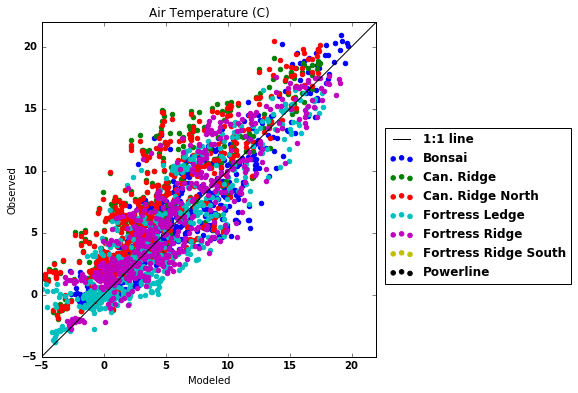

In [14]:
# Air Temperature
axe_t.legend(Station_full_names,bbox_to_anchor=[1.6, 0.2], loc='lower right')
fig1

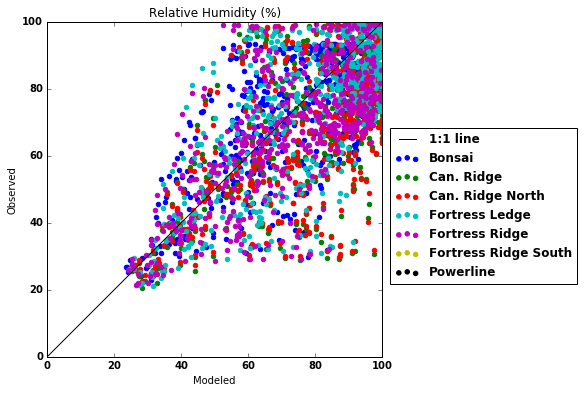

In [15]:
# Relative humidity
axe_rh.legend(Station_full_names,bbox_to_anchor=[1.6, 0.2], loc='lower right')
fig6

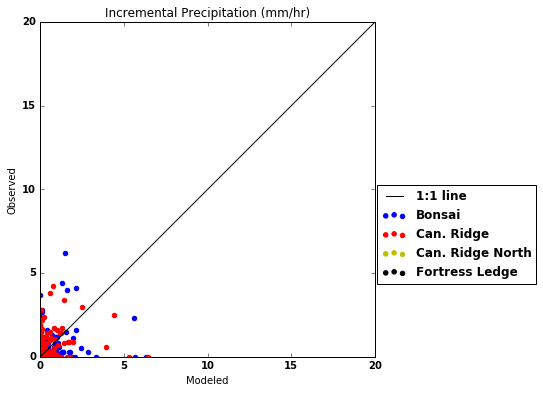

In [16]:
# Precipitation
axe_p.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig2

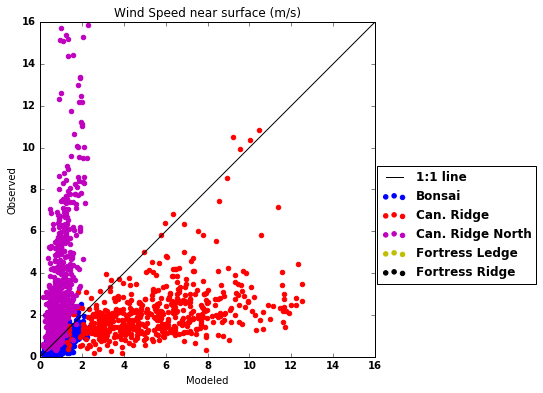

In [17]:
# Wind Speed 
axe_ws.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig3

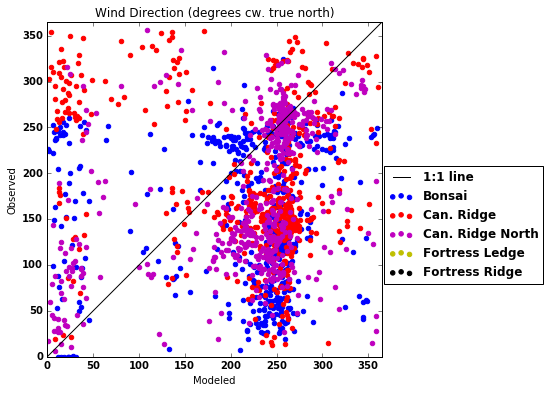

In [18]:
# Wind Direction 
axe_WD.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig7

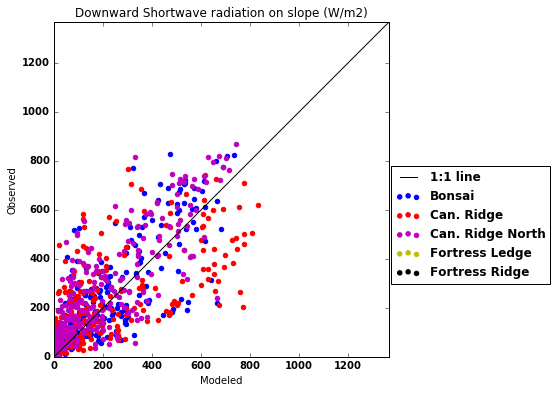

In [19]:
# Shortwave
axe_SW.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig4

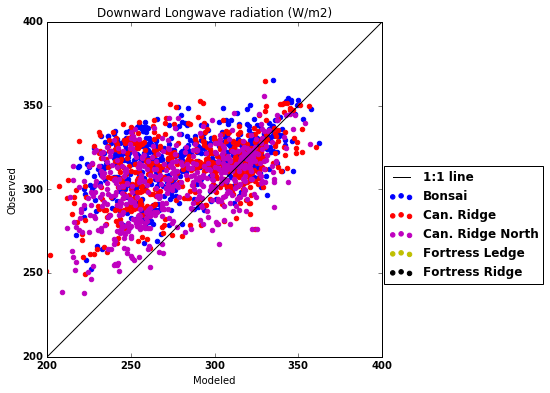

In [20]:
# longwave
axe_LW.legend(Station_full_names,bbox_to_anchor=[1.5, 0.2], loc='lower right')
fig5